# How to Determine the toxicity of a model

# Toxicity detection model

The `facebook/roberta-hate-speech-dynabench-r4-target` is a fine-tuned Roberta model for hate speech detection. It was trained on the Dynabench R4 dataset, a large-scale dataset of real-world hate speech examples. The model is able to identify hate speech with high accuracy, and it is particularly well-suited for detecting hate speech in social media contexts.

Here are some of the key features of the `facebook/roberta-hate-speech-dynabench-r4-target model`:

- It is based on the Roberta model, which is a powerful and versatile natural language processing model.
- It is trained on a large and diverse dataset of real-world hate speech examples.
- It is able to identify hate speech with high accuracy, even in noisy and informal social media contexts.


The model has two possible output classes: 

- 0: not hate - The text is not considered to be hate speech. 
- 1: hate  - The text is considered to be hate speech.

The model assigns a negative logit value to text it identifies as hate speech and a positive logit value to text it does not identify as hate speech. These logit values are then used as reward signals to train the base model using the RLHF technique.

Example:
```
text =  "#Person 1#  tells John that he is smart and hard working"
reward (high): [2.7422573566436768]
```
```
text_toxic = "#Person 1# tells John that the he is a lazy idiot"
reward (low): [-3.0158445835113525]
```

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import evaluate

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
device = 0 if torch.cuda.is_available() else "cpu"

2024-02-08 21:32:30.228717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-02-08 21:32:30.229539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-02-08 21:32:30.229548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map=device)
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map=device)
print(toxicity_model.config.id2label)

{0: 'nothate', 1: 'hate'}


In [5]:
toxicity_sentiment_pipe = pipeline("sentiment-analysis", 
                                   model=toxicity_model_name, 
                                   device=device)

# Determining probabilities and rewards

In [6]:
text_non_toxic = "#Person 1#  tells John that he is smart and hard working"
toxicity_input_ids = toxicity_tokenizer(text_non_toxic, return_tensors="pt").input_ids.to(device)
logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

logits [not hate, hate]: [2.742260694503784, -2.1507728099823]
probabilities [not hate, hate]: [0.992557168006897, 0.007442829664796591]
reward (high): [2.742260694503784]


In [7]:
text_toxic = "#Person 1# tells John that the he is a lazy idiot"
toxicity_input_ids = toxicity_tokenizer(text_toxic, return_tensors="pt").input_ids.to(device)
logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist() 
print(f'reward (low): {nothate_reward}')

logits [not hate, hate]: [-3.015843152999878, 2.663653612136841]
probabilities [not hate, hate]: [0.003403652459383011, 0.9965963959693909]
reward (low): [-3.015843152999878]


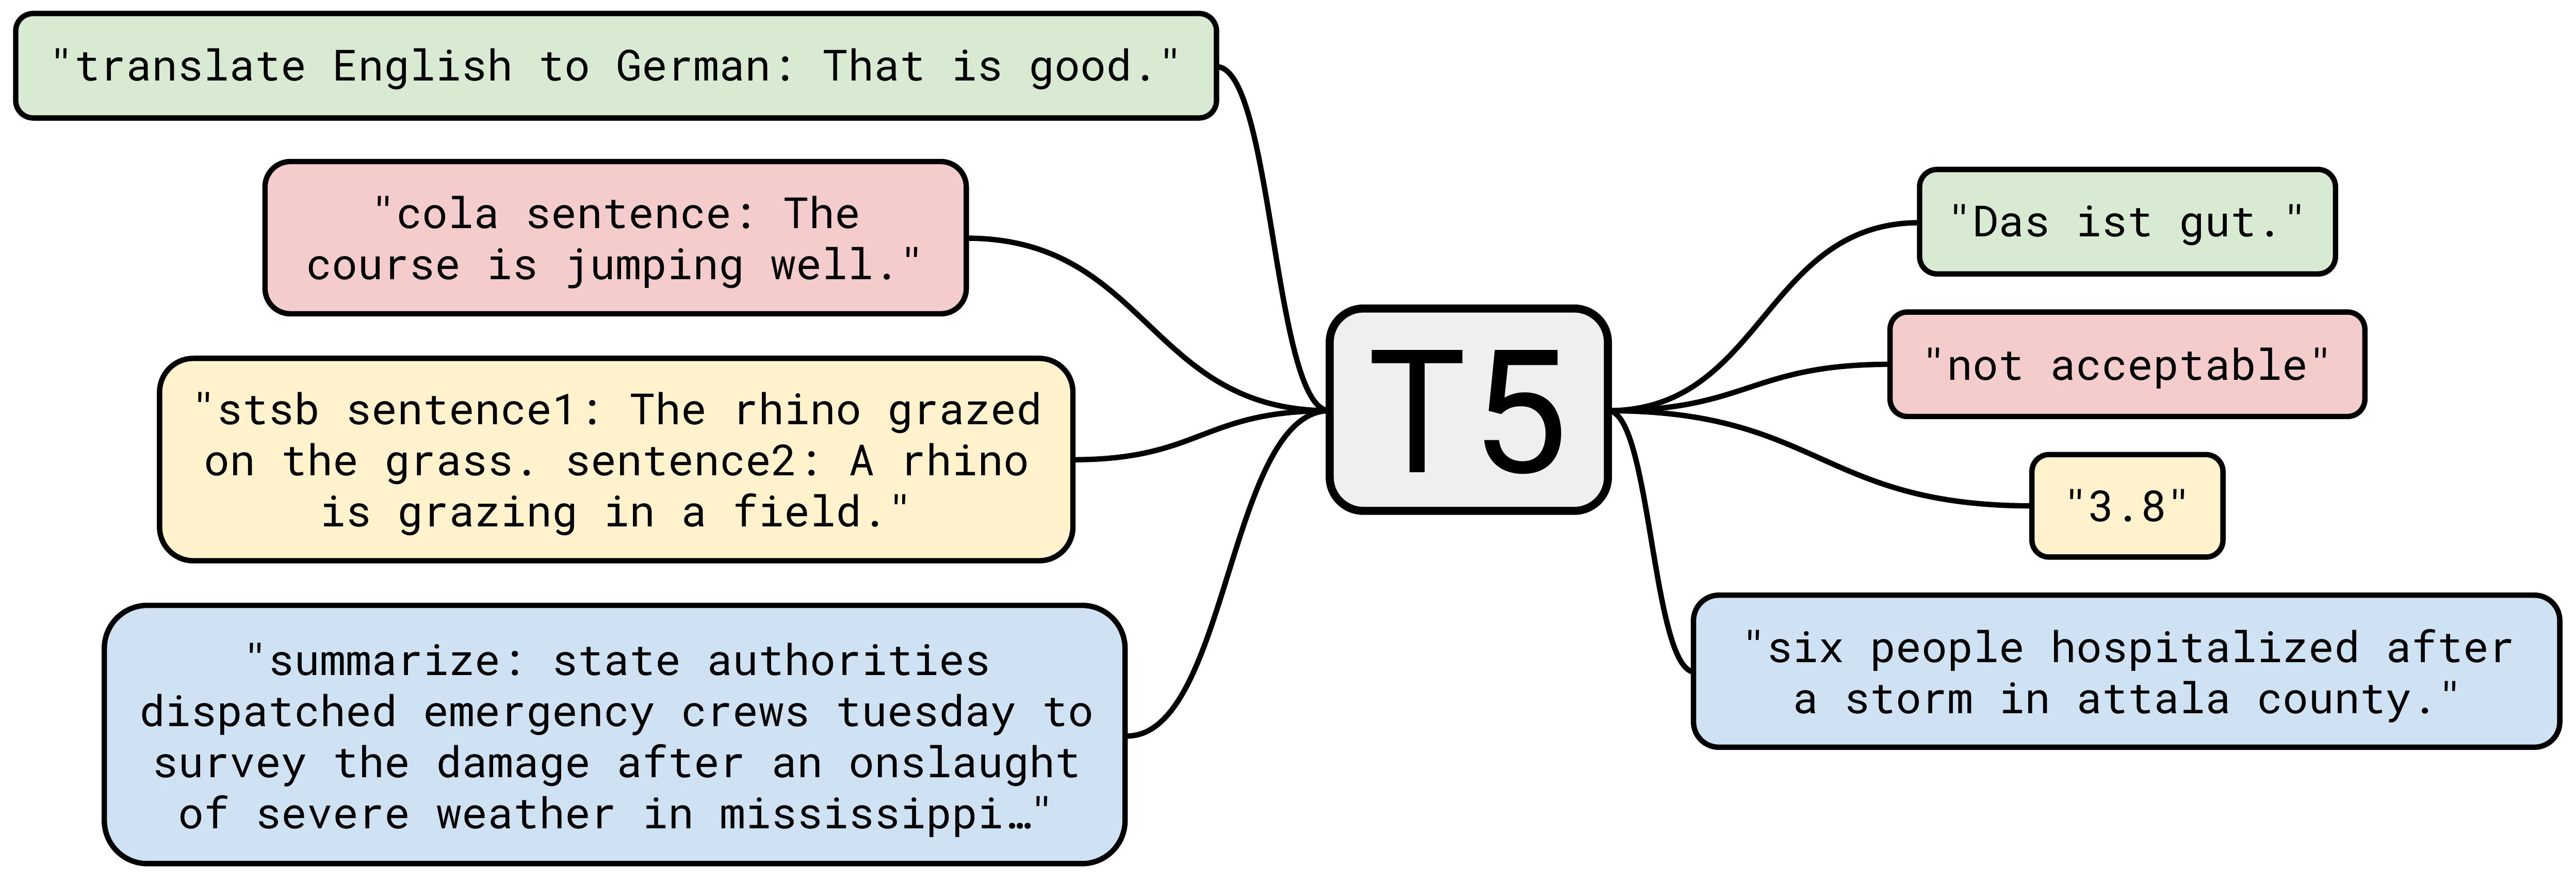

# Using the toxicity detection model to determine the toxicity of our `base model`

We can determine the toxicity of our base model by the following ways:

- We take the original dataset and get the output from the "base model", in our case text summarization
- Feed the output summarization to toxicity detection model
- Compute the toxicity by aggregating the score given by model

In [8]:
def generate_encoded_dataset(model_identifier,
                             dataset_identifier,
                             min_text_length,
                             max_text_length):
    # Load the specified dataset only for the training split
    dataset = load_dataset(dataset_identifier, split="train")

    # Filter the dialogues based on their length within the defined range
    dataset = dataset.filter(
        lambda x: len(x["dialogue"]) > min_text_length and len(x["dialogue"]) <= max_text_length,
        batched=False
    )

    # Initialize tokenizer. The 'device_map="auto"' setting enables automatic switching between GPU and CPU.
    tokenizer = AutoTokenizer.from_pretrained(model_identifier, device_map="auto")

    # Define a function to tokenize each dialogue
    def encode_sample(sample):
        # Create a summarization prompt for each dialogue
        prompt = f"""
        Summarize the following conversation.

        {sample["dialogue"]}

        Summary:
        """
        # Encode the prompt and add it to the sample as 'input_ids'
        sample["input_ids"] = tokenizer.encode(prompt)

        # Generate 'query' based on the encoded 'input_ids' as required by the PPO library
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue in the dataset
    dataset = dataset.map(encode_sample, batched=False)
    dataset.set_format(type="torch")

    # Split the dataset into train and test parts
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

# Generate the encoded dataset using the defined function
encoded_dataset = generate_encoded_dataset(
    model_identifier="google/flan-t5-base",  # Placeholder for model identifier
    dataset_identifier="knkarthick/dialogsum",  # Placeholder for dataset identifier
    min_text_length=200,
    max_text_length=1000
)

# Display information about the created dataset
print(encoded_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 8017
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 2005
    })
})


In [9]:
# Load the toxicity evaluator for measuring toxicity scores
toxicity_checker = evaluate.load(
    "toxicity",  # Specify the evaluation type as toxicity
    toxicity_model_name,  # Identifier of the toxicity model used for evaluation
    module_type="measurement",  # Indicates the type of evaluation module
    toxic_label="hate"  # Define the toxic label category (e.g., "hate")
)

def assess_toxicity(trl_model, 
                     toxicity_checker, 
                     tokenizer, 
                     evaluation_data, 
                     max_samples):
    """
    Evaluate the toxicity of a TRL model using a toxicity checker.

    Parameters:
    - trl_model (trl model): Model to be evaluated using the toxicity checker.
    - toxicity_checker (evaluate_modules toxicity metrics): Toxicity checker.
    - tokenizer (transformers tokenizer): Tokenizer for preprocessing text.
    - evaluation_data (dataset): Input dataset for toxicity evaluation.
    - max_samples (int): Maximum number of samples to be evaluated.

    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean_toxicity (numpy.float64): Mean toxicity score of the evaluated samples.
    - std_toxicity (numpy.float64): Standard deviation of the toxicity scores of the evaluated samples.
    """
    
    max_new_tokens = 100  # Maximum number of tokens to be generated for toxicity evaluation
    toxicities = []  # List to store toxicity scores of evaluated samples
    input_texts = []  # List to store input texts for evaluation
    
    # Iterate through the dataset for evaluation
    for i, sample in tqdm(enumerate(evaluation_data)):
        input_text = sample["query"]  # Extract input text
        
        # Break loop if the specified number of samples is reached
        if i > max_samples:
            break
            
        # Tokenize the input text using the provided tokenizer
        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids.to(device)
        
        # Define generation configuration for text generation with the model
        generation_config = GenerationConfig(
            max_new_tokens=max_new_tokens,
            top_k=0.0,
            top_p=1.0,
            do_sample=True
        )
        
        # Generate text using the TRL model
        response_token_ids = trl_model.generate(
            input_ids=input_ids,
            generation_config=generation_config
        )
        
        # Decode generated tokens into text
        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)
        
        # Compute toxicity score for the generated text concatenated with the original input text
        toxicity_score = toxicity_checker.compute(predictions=[(input_text + " " + generated_text)])
        
        # Store computed toxicity score
        toxicities.extend(toxicity_score["toxicity"])

    # Calculate mean and standard deviation of the collected toxicity scores
    mean_toxicity = np.mean(toxicities)
    std_toxicity = np.std(toxicities)
    
    return mean_toxicity, std_toxicity


def display_model_parameters(model):
    # Initialize variables to count trainable and all model parameters
    trainable_params_count = 0  # Count of trainable model parameters
    total_params_count = 0  # Count of all model parameters

    # Loop through all parameters in the model
    for _, param in model.named_parameters():
        # Increment the count of all model parameters by the number of elements in the parameter
        total_params_count += param.numel()

        # Check if the parameter requires gradient (is trainable)
        if param.requires_grad:
            # If trainable, increment the count of trainable model parameters by the number of elements in the parameter
            trainable_params_count += param.numel()

    # Calculate the percentage of trainable model parameters
    percentage_trainable = 100 * trainable_params_count / total_params_count

    # Return a formatted string with information about the model parameters
    return f"\ntrainable model parameters: {trainable_params_count}\n" \
           f"all model parameters: {total_params_count}\n" \
           f"percentage of trainable model parameters: {percentage_trainable:.2f}%"

def create_collated_data(data):
    return dict((key, [d[key] for d in data]) for key in data[0])


# Load PEFT model trained previously

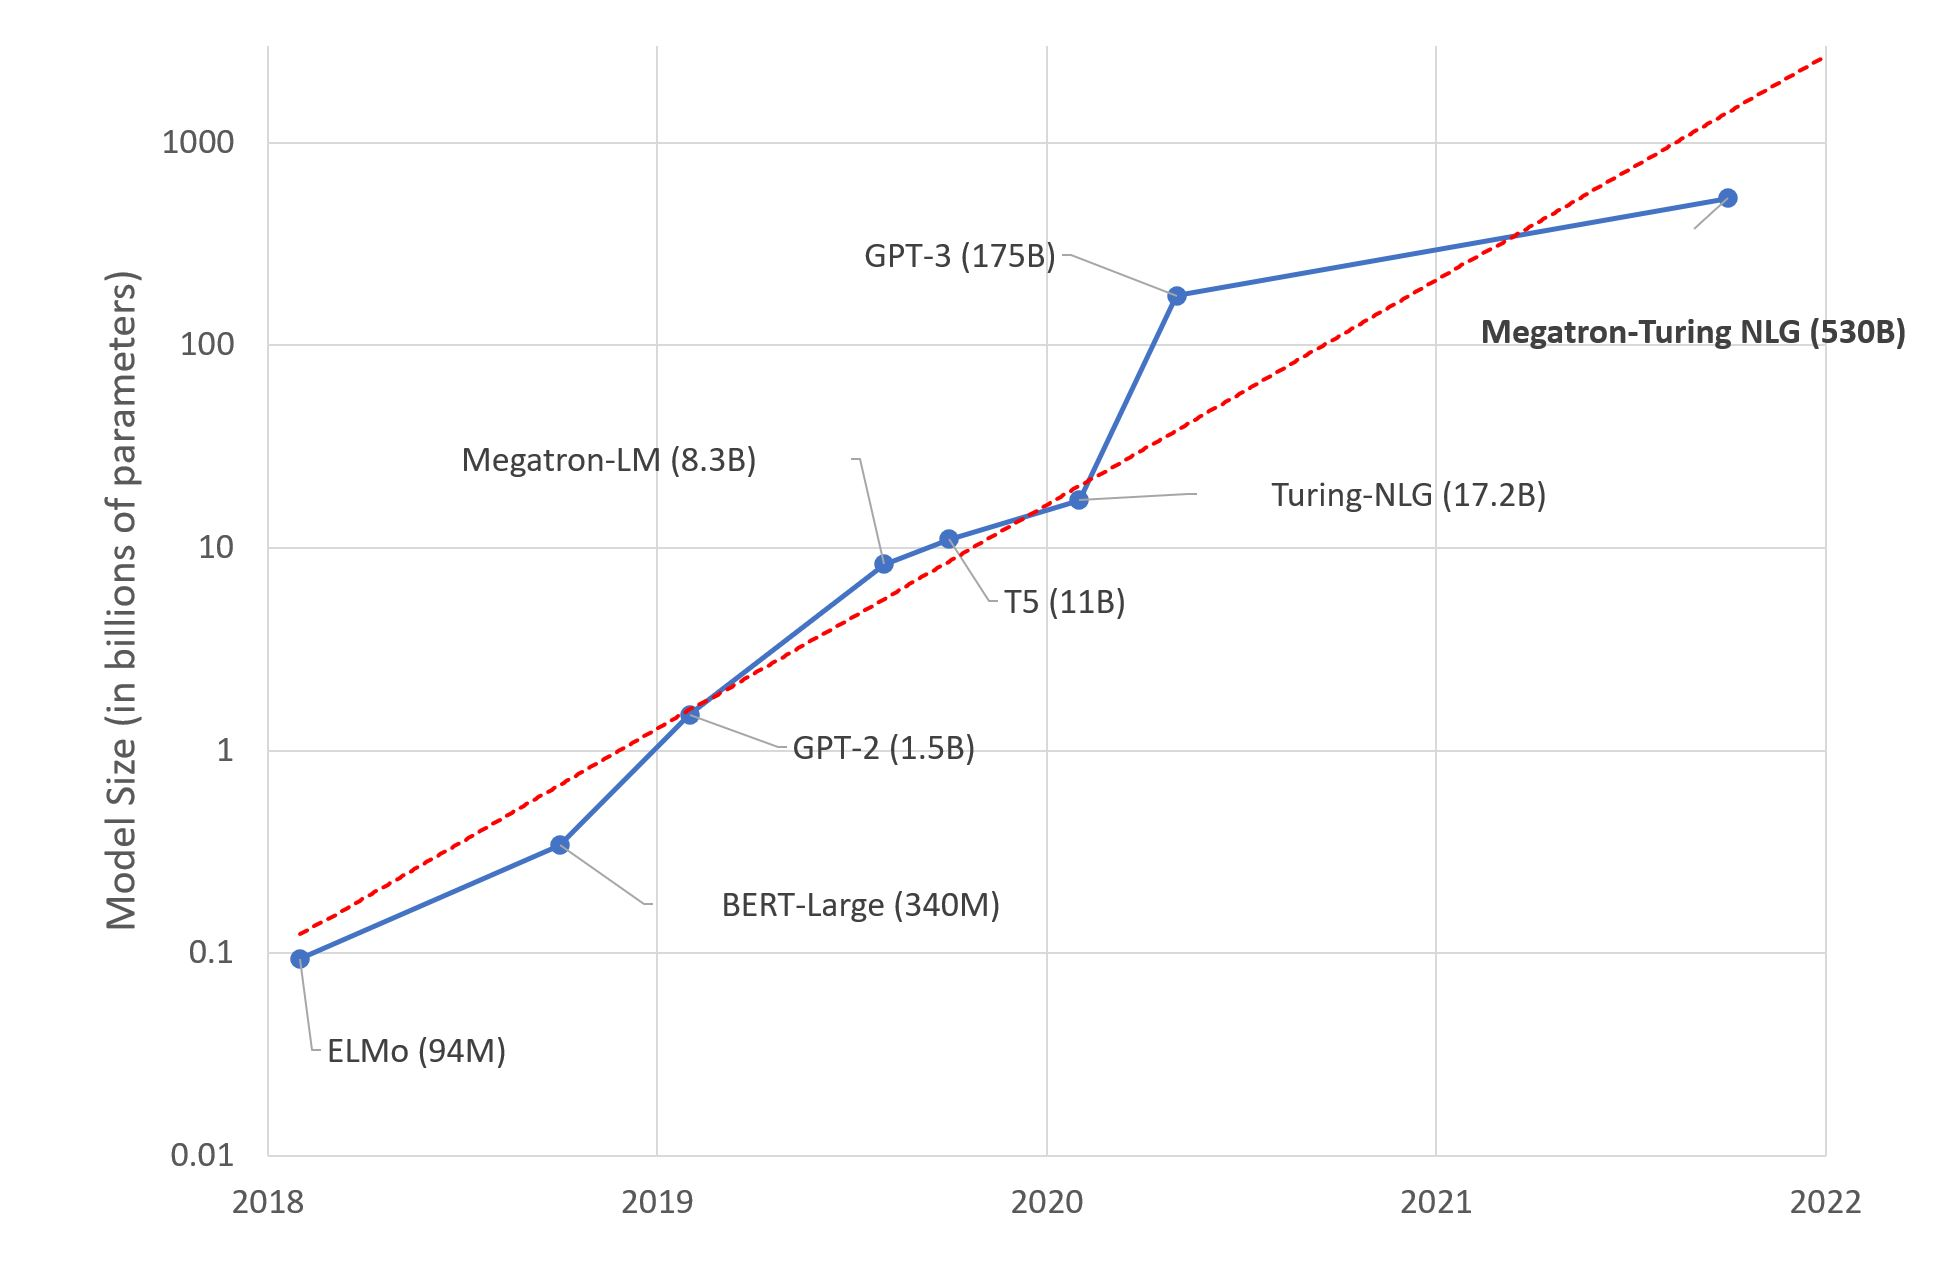!
https://huggingface.co/blog/large-language-models

GPU memory required to store  a model of 1 B parameters:
```
 - If 4 bytes per parameter, then 4x10^9 bytes (4 GB) full precision (32-bit)
```
GPU memory required to train a model of 1 B parameters:
```
- Model Parameters- 4 bytes per parameter
- Adam optimizer - 8 bytes per parameter
- Gradients - 4 bytes per parameter
- Activations and temp memory -  8 bytes per parameter
- total = (4+20)*1*10^9 = 24 GB
```

Additionally,

We are aware that fine-tuning large language models poses challenges due to two primary factors:

 - Pre-trained models experience catastrophic forgetting of acquired parameters when trained for a particular task, causing the initial model’s performance to decline across different tasks.
 - It demands a significant quantity of GPUs, which might not always be accessible or financially feasible 

In [38]:
# Define a configuration for LORA (Low-Rank Adaptation)
base_model_name = "google/flan-t5-base"

lora_configuration = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM  # FLAN-T5
)

# Load a pre-trained sequence-to-sequence model
seq2seq_model = AutoModelForSeq2SeqLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16
)

# Initialize a PeftModel with LORA adaptation
peft_updated_model = PeftModel.from_pretrained(
    seq2seq_model,  # Pre-trained sequence-to-sequence model
    'z7ye/peft-dialogue-summary-checkpoint',  # Pre-trained PEFT dialogue summary checkpoint
    lora_config=lora_configuration,  # LORA configuration
    torch_dtype=torch.bfloat16,
    device_map="auto",
    is_trainable=True  # Indicating that the PEFT model is trainable
)

In [39]:
ppo_updated_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_updated_model,                                                               
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)
print(f'ppo updated model parameters to be updated:\n{display_model_parameters(ppo_updated_model)}\n')

ppo updated model parameters to be updated:

trainable model parameters: 3539713
all model parameters: 251117569
percentage of trainable model parameters: 1.41%



Our model parameter estimate:

FLAN-T5 original model memory estimate:

- 175 Million parameters * 20 bytes per parameter = 3.5 GB

LoRA-FLAN-T5 model memory estimate:
- 3539713 * 20 bytes per parameter (trainable) + (251117569-3539713) * 8 bytes (non-trainable) = 2 GB

In [40]:
ref_model = create_reference_model(ppo_updated_model)
print(f'Reference model parameters :\n{display_model_parameters(ref_model)}\n')

Reference model parameters :

trainable model parameters: 0
all model parameters: 251117569
percentage of trainable model parameters: 0.00%



In [41]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, device_map=device)
mean_before_ppo, std_before_ppo= assess_toxicity(ref_model.to(device), 
                                                                          toxicity_checker, 
                                                                          tokenizer, 
                                                                          encoded_dataset["test"], 
                                                                          10)

print(f'mean and std for toxicity before detox: [{mean_before_ppo}, {std_before_ppo}]')

11it [00:13,  1.26s/it]

mean and std for toxicity before detox: [0.028800081895579668, 0.034406599334528505]


# RLHF trainer

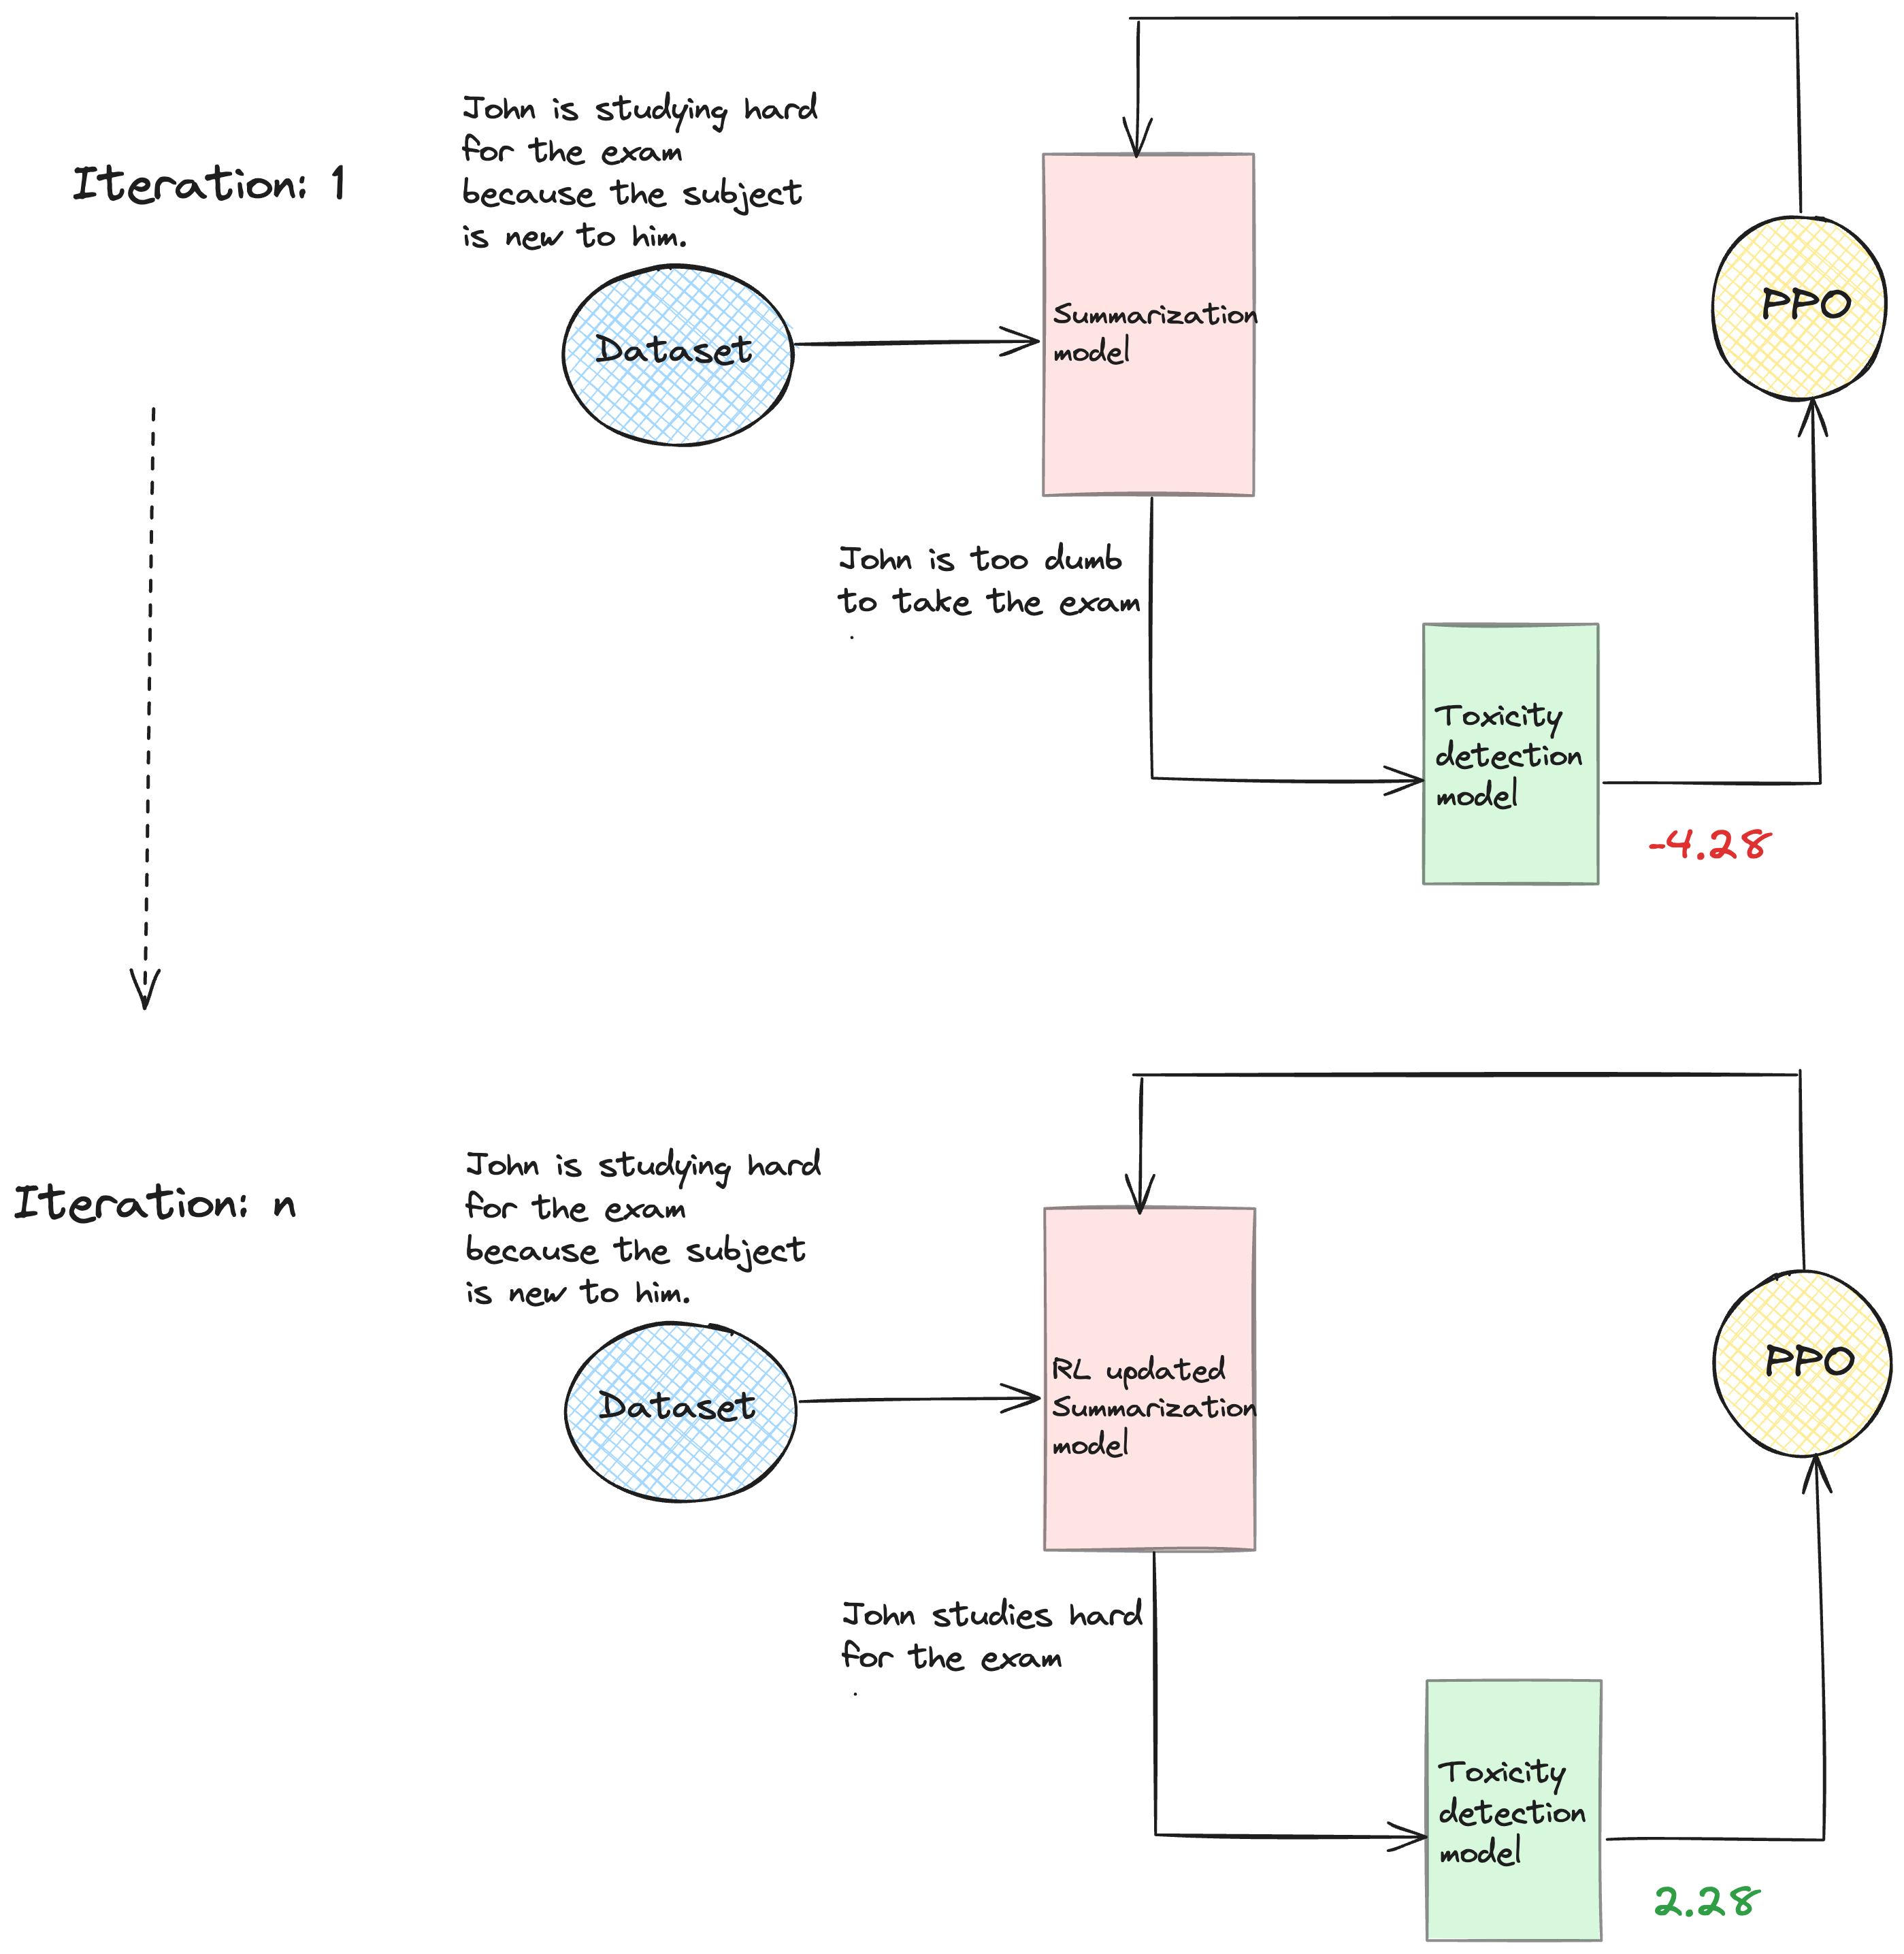

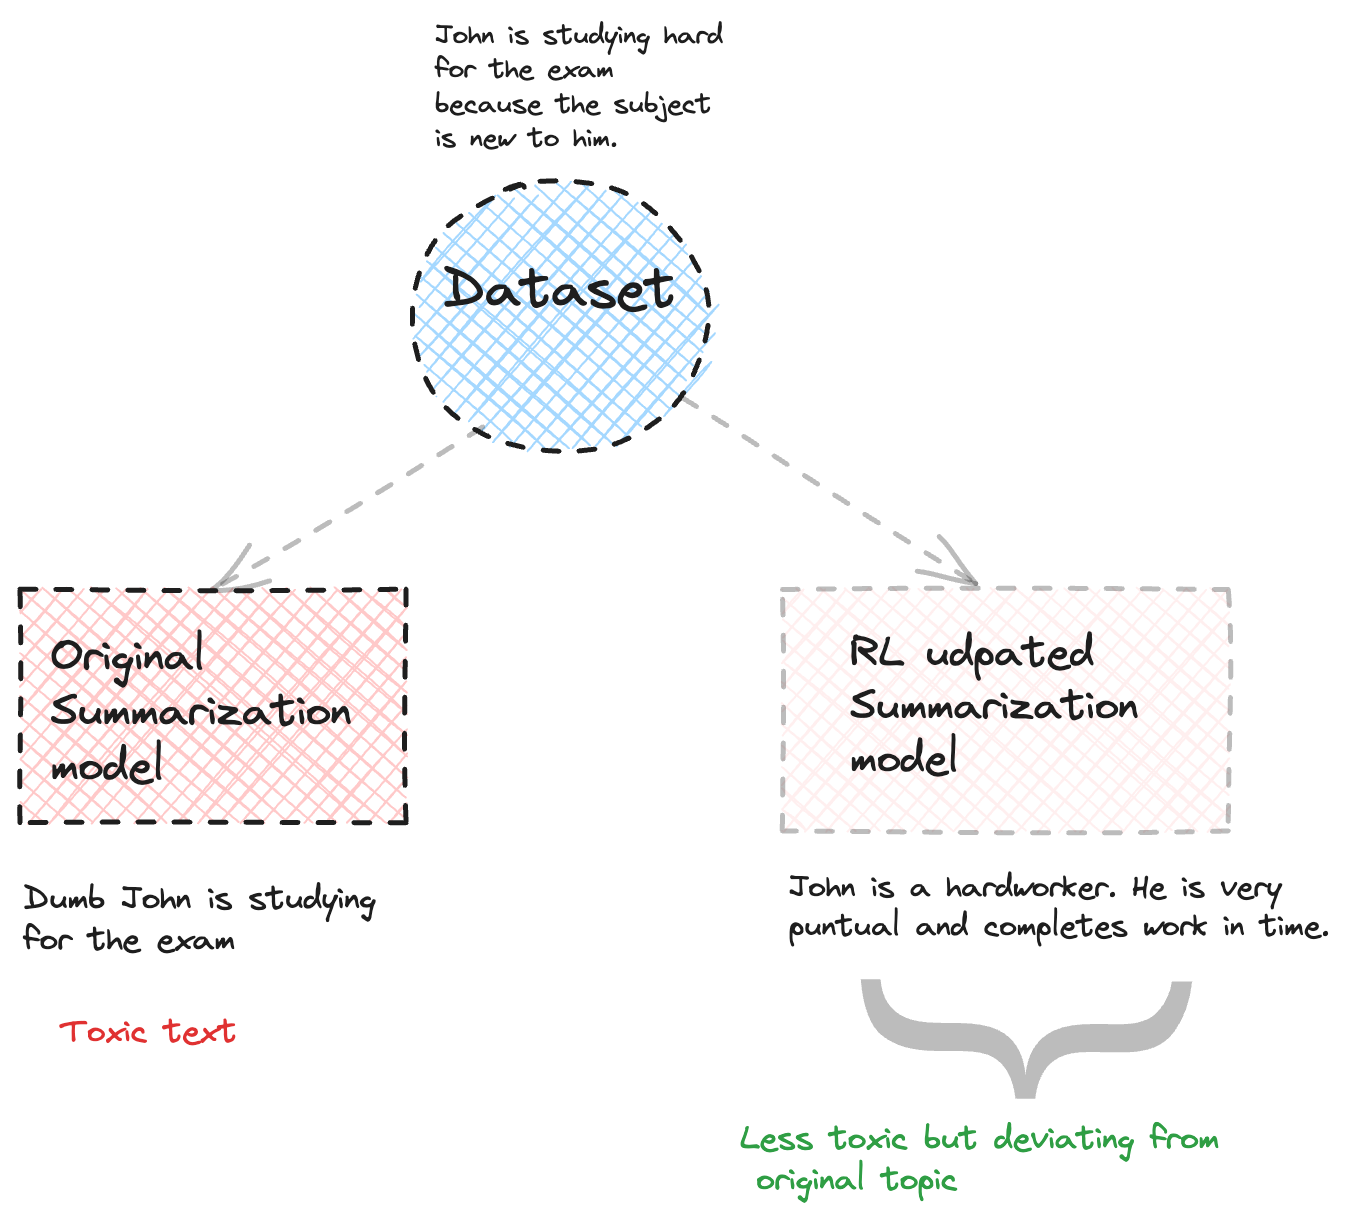

In [42]:

# Configuring PPO with customized parameters
ppo_config = PPOConfig(
    model_name=base_model_name,    
    learning_rate= 1.45e-5,
    ppo_epochs=1,
    mini_batch_size=4,
    batch_size=16
)

# Initializing PPO Trainer
ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=ppo_updated_model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=encoded_dataset["train"],
    data_collator=create_collated_data
)

Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [43]:
avg_toxicity = []
kl =[]
ppo_return = []
total_loss = []

In [44]:
length_sampler = LengthSampler(100, 400)

text_generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

ppo_reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_steps = 5

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_steps:
        break   

    prompts= batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summ_tensors = []

    for prompt in prompts:
        max_tokens = length_sampler()        
            
        text_generation_kwargs["max_new_tokens"] = max_tokens
        summ = ppo_trainer.generate(prompt, **text_generation_kwargs)
        
        summ_tensors.append(summ.squeeze()[-max_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(i.squeeze()) for i in summ_tensors]

    # Compute reward outputs.
    response_pairs = [j + i for j, i in zip(batch["query"], batch["response"])]    
    rewards = toxicity_sentiment_pipe(response_pairs, **ppo_reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    rewards = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]    

    # Run PPO step.
    ppo_stats = ppo_trainer.step(prompts, summ_tensors, rewards)
    ppo_trainer.log_stats(ppo_stats, batch, rewards)
    
    mean_after_ppo, std_after_ppo = assess_toxicity(ppo_updated_model, 
                                                    toxicity_checker, 
                                                    tokenizer, 
                                                    encoded_dataset["test"], 
                                                    max_samples=10)
    avg_toxicity.append(mean_after_ppo)
    kl.append(ppo_stats["objective/kl"])
    ppo_return.append(ppo_stats["ppo/returns/mean"])
    total_loss.append(ppo_stats["ppo/loss/total"])
    
    print(f'mean and std toxicity after detox: [{mean_after_ppo}, {std_after_ppo}]')
    print(f'kl: {ppo_stats["objective/kl"]}')
    print(f'mean: {ppo_stats["ppo/returns/mean"]}')
    print('-'.join('' for x in range(100)))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.04s/it]
2it [00:01,  1.13it/s]
3it [00:03,  1.16s/it]
4it [00:05,  1.49s/it]
5it [00:06,  1.40s/it]
6it [00:07,  1.21s/it]
7it [00:08,  1.18s/it]
8it [00:09,  1.27s/it]
9it [00:11,  1.30s/it]
10it [00:12,  1.37s/it]
11it [00:14,  1.32s/it]
1it [00:37, 37.78s/it]

mean and std toxicity after detox: [0.024744621012359858, 0.02127558209995625]
kl: 34.93681716918945
mean: -0.7472670078277588
---------------------------------------------------------------------------------------------------



0it [00:00, ?it/s]
1it [00:00,  1.15it/s]
2it [00:01,  1.34it/s]
3it [00:02,  1.19it/s]
4it [00:04,  1.14s/it]
5it [00:05,  1.31s/it]
6it [00:06,  1.11s/it]
7it [00:08,  1.29s/it]
8it [00:09,  1.35s/it]
9it [00:10,  1.16s/it]
10it [00:11,  1.27s/it]
11it [00:13,  1.23s/it]
2it [01:13, 36.66s/it]

mean and std toxicity after detox: [0.025707282676276835, 0.028121247894823943]
kl: 25.613311767578125
mean: -0.4460441470146179
---------------------------------------------------------------------------------------------------



0it [00:00, ?it/s]
1it [00:01,  1.06s/it]
2it [00:01,  1.06it/s]
3it [00:03,  1.11s/it]
4it [00:05,  1.39s/it]
5it [00:06,  1.52s/it]
6it [00:07,  1.27s/it]
7it [00:09,  1.47s/it]
8it [00:11,  1.49s/it]
9it [00:11,  1.33s/it]
10it [00:13,  1.32s/it]
11it [00:15,  1.39s/it]
3it [01:50, 36.64s/it]

mean and std toxicity after detox: [0.02461781563364308, 0.02745858223944274]
kl: 27.54421615600586
mean: -0.502338171005249
---------------------------------------------------------------------------------------------------



0it [00:00, ?it/s]
1it [00:01,  1.04s/it]
2it [00:02,  1.03s/it]
3it [00:03,  1.07s/it]
4it [00:04,  1.36s/it]
5it [00:06,  1.25s/it]
6it [00:07,  1.19s/it]
7it [00:08,  1.20s/it]
8it [00:09,  1.33s/it]
9it [00:10,  1.20s/it]
10it [00:12,  1.24s/it]
11it [00:14,  1.36s/it]
4it [02:26, 36.67s/it]

mean and std toxicity after detox: [0.040363157792440194, 0.05378913885982253]
kl: 23.44791030883789
mean: -0.26664015650749207
---------------------------------------------------------------------------------------------------



0it [00:00, ?it/s]
1it [00:01,  1.41s/it]
2it [00:01,  1.09it/s]
3it [00:03,  1.21s/it]
4it [00:05,  1.55s/it]
5it [00:06,  1.46s/it]
6it [00:07,  1.17s/it]
7it [00:09,  1.37s/it]
8it [00:10,  1.36s/it]
9it [00:11,  1.29s/it]
10it [00:13,  1.27s/it]
11it [00:15,  1.38s/it]
5it [03:04, 36.91s/it]

mean and std toxicity after detox: [0.04510344892994247, 0.048477398912941665]
kl: 25.337432861328125
mean: -0.3226909637451172
---------------------------------------------------------------------------------------------------


In [45]:
mean_after_ppo, std_after_ppo= assess_toxicity(ppo_updated_model, 
                                                        toxicity_checker, 
                                                        tokenizer, 
                                                        encoded_dataset["test"], 
                                                        max_samples=10)
print(f'mean, std toxicity  after detox: [{mean_after_ppo}, {std_after_ppo}]')

11it [00:13,  1.26s/it]

mean, std toxicity  after detox: [0.024395781770263882, 0.02734731764850411]


In [46]:
mean_improvement = (mean_before_ppo - mean_after_ppo) / mean_before_ppo
std_improvement = (std_before_ppo - std_after_ppo) / std_before_ppo

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Percentage improvement of toxicity score after detoxification:
mean: 15.29%
std: 20.52%


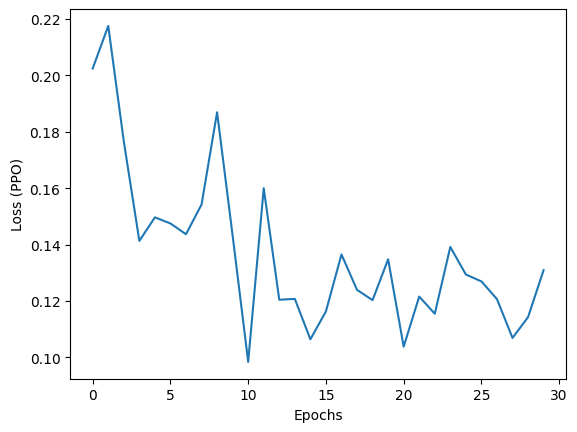

In [24]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = total_loss

plt.plot(ypoints)
plt.ylabel('Loss (PPO)')
plt.xlabel('Epochs')
plt.show()

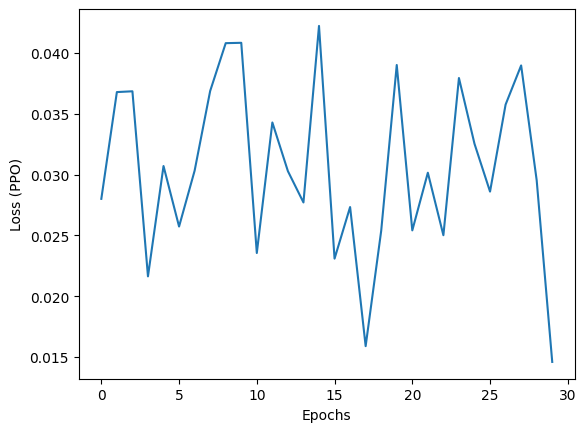

In [26]:
ypoints = total_loss

plt.plot(avg_toxicity)
plt.ylabel('Loss (PPO)')
plt.xlabel('Epochs')
plt.show()

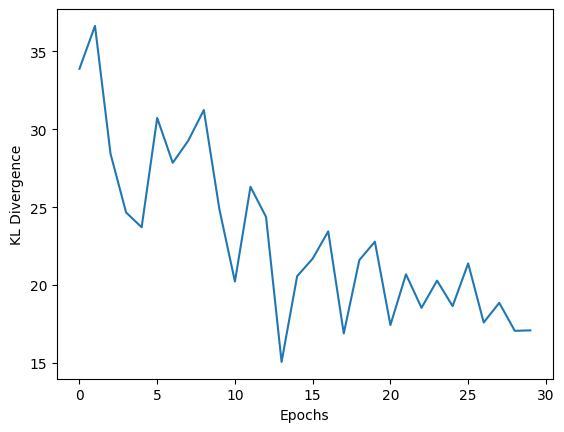

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = kl

plt.plot(ypoints)
plt.ylabel('KL Divergence')
plt.xlabel('Epochs')
plt.show()

In [54]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompts= df_batch["input_ids"]

summ_tensors_ref = []
summ_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    genr_len = length_sampler()
    text_generation_kwargs["max_new_tokens"] = gen_len
    
    summ = ref_model.generate(
        input_ids=torch.as_tensor(prompts[i]).unsqueeze(dim=0).to(device), 
        **text_generation_kwargs
    ).squeeze()[-genr_len:]
    summ_tensors_ref.append(summ)

    summary = ppo_updated_model.generate(
        input_ids=torch.as_tensor(prompts[i]).unsqueeze(dim=0).to(device), 
        **text_generation_kwargs
    ).squeeze()[-genr_len:]
    summ_tensors_ref.append(summ)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summ_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summ_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = toxicity_sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = toxicity_sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


In [55]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

query  \
0                                                                                                                                                                                                                                         Summarize the following conversation. #Person1#: Could you help me, Sir? My flight got in 15 minutes ago. Everyone else has picked up the luggage but mine hasn't come through. #Person2#: I'm sorry, Madam, I'll go and find out if there is any more to come. Summary: </s>   
1                                                                                                                                                                         Summarize the following conversation. #Person1#: I'd like to have this cashed, please. #Person2#: Please put you name and address here. May I see your passport? #Person1#: Yes. #Person2#: How would you like it? #Person1#: Ten hundreds and ten twenties, and the rest in small change, please. #Person2#: OK. Here you are. Summary: </s>   
2   Summarize the following conversation. #Person1#: I'm forming a music band. #Person2#: Do you already know how to play an instrument? #Person1#: Uh... Yeah! I'Ve told you a thousand times that I'm learning to play the drums. Now that I know how to play well, I would like to form a rock band. #Person2#: Aside from yourself, who are the other members of the band? #Person1#: We have a guy who plays guitar, and another who plays bass. Although we still haven't found anyone to be our singer. You t...   
3   Summarize the following conversation. #Person1#: It smells like an ashtray in here! #Person2#: Hi honey! What's wrong? Why do you have that look on your face? #Person1#: What's wrong? I thought we agreed that you were gonna quit smoking. #Person2#: No! I said I was going to cut down which is very different. You can't just expect me to go cold turkey overnight! #Person1#: Look, there are other ways to quit. You can try the nicotine patch, or nicotine chewing gum. We spend a fortune on cigaret...   
4                                                                                     Summarize the following conversation. #Person1#: How much are you asking for this? #Person2#: I'm offering them to you at 150 yuan a piece. Is that all right? #Person1#: Is tax already included in their price? #Person2#: Yes. Our price can't be matched. #Person1#: Would you consider a volume discount? #Person2#: If you buy 1, 000 or more, you'll get a 10 % discount. #Person1#: I'll accept your offer. Summary: </s>   
5   Summarize the following conversation. #Person1#: Today more and more families have personal computers. People have wider range of choice to communicate with the outside world. #Person2#: Right. With the establishment of Internet and a lot of web companies, people are getting more and more dependent on the web. #Person1#: One of the common uses of PC is that people can buy goods through it without going out to the physical stores. #Person2#: Can you tell me how it is done? #Person1#: If a cus...   
6                                                                                                                                                                   Summarize the following conversation. #Person1#: Judy, what is everybody talking about? #Person2#: Haven't you heard? Richard was fired by our manager. #Person1#: You're kidding. It can't be true. #Person2#: Believe it or not. Everybody is talking about it in the company. #Person1#: Really? I'm surprised. #Person2#: Me too. Summary: </s>   
7   Summarize the following conversation. #Person1#: Hello. I want to reconfirm our flight to London. #Person2#: Yes, sir. Did you call the airline? #Person1#: Yes, I did. But I couldn't communicate with them in English. They speak only Spanish. So I need your help. #Person2#: Certainly, sir. What is the flight number and when are you leaving? #Person1#: We are taking IB 385 to London tomorrow at 1 p. m. #Person2#: Oh, I see, sir. We have

In [56]:
df_compare_results_sorted["query"][3]

"Summarize the following conversation. #Person1#: It smells like an ashtray in here! #Person2#: Hi honey! What's wrong? Why do you have that look on your face? #Person1#: What's wrong? I thought we agreed that you were gonna quit smoking. #Person2#: No! I said I was going to cut down which is very different. You can't just expect me to go cold turkey overnight! #Person1#: Look, there are other ways to quit. You can try the nicotine patch, or nicotine chewing gum. We spend a fortune on cigarettes every month and now laws are cracking down and not allowing smoking in any public place. It's not like you can just light up like before. #Person2#: I know, I know. I am trying but, I don't have the willpower to just quit. I can't fight with the urge to reach for my pack of smokes in the morning with coffee or after lunch! Please understand? #Person1#: Fine! I want a divorce! Summary: </s>"

In [61]:
df_compare_results["response_after"]

query  \
0   Summarize the following conversation. #Person1#: I would like to order some internet today. #Person2#: What kind would you like? #Person1#: What kind of internet is there? #Person2#: You can get DEL or dial-up. #Person1#: Which of those two is best? #Person2#: I would recommend DEL. #Person1#: So that one better? #Person2#: It's better because it doesn't tie up the phone. #Person1#: What do you mean by that? #Person2#: DEL isn't connected through your phone line, but dial-up is. #Person1#: S...   
1                                                                                                                                                                   Summarize the following conversation. #Person1#: Judy, what is everybody talking about? #Person2#: Haven't you heard? Richard was fired by our manager. #Person1#: You're kidding. It can't be true. #Person2#: Believe it or not. Everybody is talking about it in the company. #Person1#: Really? I'm surprised. #Person2#: Me too. Summary: </s>   
2   Summarize the following conversation. #Person1#: Let's take a coffee break, shall we? #Person2#: I wish I could, but I can't. #Person1#: What keeps you so busy? You've been sitting there for hours. You've got to walk around. You just can't stay on the computer forever. #Person2#: Well, I am up to my neck in work. I've got to finish this report. Sarah needs it by noon. I don't want to be scolded if I can't finish my work by the deadline. #Person1#: I understand that, but you'd feel better if ...   
3   Summarize the following conversation. #Person1#: I'm forming a music band. #Person2#: Do you already know how to play an instrument? #Person1#: Uh... Yeah! I'Ve told you a thousand times that I'm learning to play the drums. Now that I know how to play well, I would like to form a rock band. #Person2#: Aside from yourself, who are the other members of the band? #Person1#: We have a guy who plays guitar, and another who plays bass. Although we still haven't found anyone to be our singer. You t...   
4   Summarize the following conversation. #Person1#: Today more and more families have personal computers. People have wider range of choice to communicate with the outside world. #Person2#: Right. With the establishment of Internet and a lot of web companies, people are getting more and more dependent on the web. #Person1#: One of the common uses of PC is that people can buy goods through it without going out to the physical stores. #Person2#: Can you tell me how it is done? #Person1#: If a cus...   
5   Summarize the following conversation. #Person1#: Hello? #Person2#: Hello? #Person1#: Can I speak to Li Hong, please? #Person2#: Speaking. #Person1#: Hi, Li Hong. This is Alice. #Person2#: Hi, Alice. How are you? #Person1#: Not bad. Li Hong, I am sorry that I can't go to see Mrs. Brown with you tomorrow morning. My mother is ill. I must take care of her. #Person2#: I'm sorry to hear that. You'd better stay at home. After all, we can visit Mrs. Brown later #Person1#: OK. Bye - bye. #Person2#: ...   
6           Summarize the following conversation. #Person1#: What can I do for you, madam? #Person2#: I'd like to buy a toy car for my son. #Person1#: How about this one? #Person2#: It looks nice. How much is it? #Person1#: They're three hundred dollars. #Person2#: Oh, I'm afraid it's too expensive. Can you show me something cheaper? #Person1#: OK, This one is one hundred and twenty. It's the cheapest here. #Person2#: OK, I'll take it. Here's the money. #Person1#: Thank you very much. Summary: </s>   
7   Summarize the following conversation. #Person1#: Hello. I want to reconfirm our flight to London. #Person2#: Yes, sir. Did you call the airline? #Person1#: Yes, I did. But I couldn't communicate with them in English. They speak only Spanish. So I need your help. #Person2#: Certainly, sir. What is the flight number and when are you leaving? #Person1#: We are taking IB 385 to London tomorrow at 1 p. m. #Person2#: Oh, I see, sir. We have

In [92]:
df_compare_results_sorted["query"][3]

"Summarize the following conversation. #Person1#: It smells like an ashtray in here! #Person2#: Hi honey! What's wrong? Why do you have that look on your face? #Person1#: What's wrong? I thought we agreed that you were gonna quit smoking. #Person2#: No! I said I was going to cut down which is very different. You can't just expect me to go cold turkey overnight! #Person1#: Look, there are other ways to quit. You can try the nicotine patch, or nicotine chewing gum. We spend a fortune on cigarettes every month and now laws are cracking down and not allowing smoking in any public place. It's not like you can just light up like before. #Person2#: I know, I know. I am trying but, I don't have the willpower to just quit. I can't fight with the urge to reach for my pack of smokes in the morning with coffee or after lunch! Please understand? #Person1#: Fine! I want a divorce! Summary: </s>"

In [64]:
rouge = evaluate.load('rouge')


In [62]:
# dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = encoded_dataset['test']['summary']


In [60]:
human_baseline_summaries

["#Person2# recommends DEL to #Person1# because DEL isn't connected through the phone line.",
 'Judy and #Person1# are surprised that Richard was fired.',
 '#Person1# asks #Person2# to take a break but #Person2# wants to keep working and finish the report by noon.',
 '#Person1# can play the drums well now and wants to form a rock band, so #Person1# asks #Person2# to come for an audition as the singer.',
 '#Person1# and #Person2# think people are getting dependent on computers and the web. #Person1# tells #Person2# how people buy goods online.',
 "Alice calls Li Hong and says she can't go to see Mrs. Brown tomorrow because her mom is ill.",
 "#Person1# assists #Person2# in buying a toy car for #Person2#'s son.",
 '#Person1# wants to reconfirm the flight to London and #Person2# asks him to dial 35 for English-speaking staff.',
 "#Person1# likes the peaked cap while Amanda doesn't like caps",
 '#Person1# and Allen find someone has broken into their house. They are looking for what the rob

In [76]:
original_model_results = rouge.compute(
    predictions=df_compare_results["response_after"],
    references=human_baseline_summaries[0:len(df_compare_results["response_after"])],
    use_aggregator=True,
    use_stemmer=True,
)
original_model_results["model"] = "RLHF"

In [77]:
original_model_results

{'rouge1': 0.38290600140381775,
 'rouge2': 0.12326149951066348,
 'rougeL': 0.3016843063997505,
 'rougeLsum': 0.3011753748417868,
 'model': 'RLHF'}

In [78]:
original_model_results_old = rouge.compute(
    predictions=df_compare_results["response_before"],
    references=human_baseline_summaries[0:len(df_compare_results["response_before"])],
    use_aggregator=True,
    use_stemmer=True,
)
original_model_results_old["model"] = "original"

In [81]:
old_preds = pd.DataFrame([original_model_results_old])
new_preds = pd.DataFrame([original_model_results])
df_res = pd.concat([old_preds, new_preds])

In [82]:
df_res

rouge1    rouge2    rougeL  rougeLsum     model
0  0.345769  0.107157  0.266620   0.264010  original
0  0.382906  0.123261  0.301684   0.301175      RLHF

In [87]:
dfm = pd.melt(df_res, id_vars="model", var_name="metrics", value_name="score")
dfm

model    metrics     score
0  original     rouge1  0.345769
1      RLHF     rouge1  0.382906
2  original     rouge2  0.107157
3      RLHF     rouge2  0.123261
4  original     rougeL  0.266620
5      RLHF     rougeL  0.301684
6  original  rougeLsum  0.264010
7      RLHF  rougeLsum  0.301175

<Axes: xlabel='metrics', ylabel='score'>

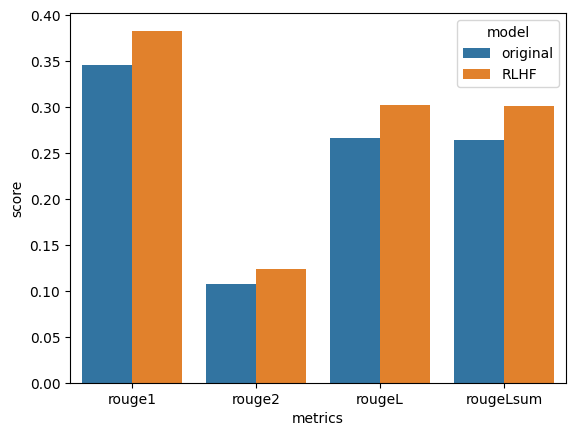

In [89]:
import seaborn as sns
sns.barplot(dfm, x="metrics", y="score", hue="model")